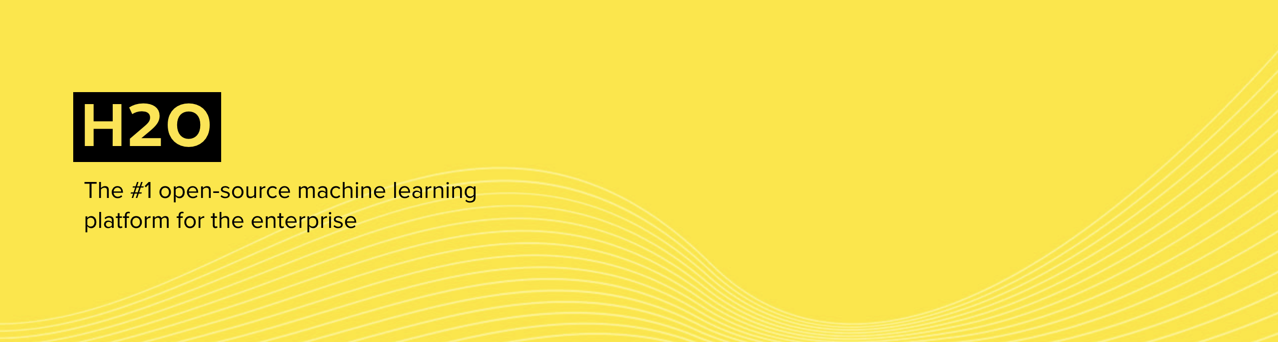

## License 

<span style="color:gray"> Copyright 2022 David Whiting and Greg Keys

<span style="color:gray"> Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

<span style="color:gray">     http://www.apache.org/licenses/LICENSE-2.0

<span style="color:gray"> Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<span style="color:gray"> **DISCLAIMER:** This notebook is not legal compliance advice. </span>

<hr style="background-color: gray;height: 2.0px;"/>

# Chapter 7 - Lending Club

## Start the H2O-3 cluster

We start the cluster assuming it is locally installed. Your startup commands will depend on your setup. _See Appendix A for details._

Your numeric results may vary somewhat from that shown in the text if the H2O cluster version or the number of nodes and cores available to the H2O server are different from what was used in the book.

In [ ]:
import h2o
h2o.init()

## Recreate the gbm model from Chapter 5.

In [ ]:
input_csv = "https://s3.amazonaws.com/data.h2o.ai/Machine-Learning-at-Scale/lending_club/loans.csv"

loans = h2o.import_file(input_csv)

In [ ]:
loans["bad_loan"] = loans["bad_loan"].asfactor()
loans["issue_d_year"] = loans["issue_d"].year().asfactor()
loans["issue_d_month"] = loans["issue_d"].month().asfactor()

train, valid, test = loans.split_frame(
    seed = 25,
    ratios = [0.6, 0.2],
    destination_frames = ["train", "valid", "test"])

train_cv, test_cv = loans.split_frame(
    seed = 25,                        
    ratios = [0.8],                                      
    destination_frames = ["train_cv", "test_cv"])

response = "bad_loan"
omit = ["issue_d", response]
predictors = list(set(loans.columns) - set(omit))

In [ ]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm = H2OGradientBoostingEstimator(seed = 25)
gbm.train(x = predictors,
          y = response,
          training_frame = train,
          validation_frame = valid,
          model_id = "gbm_baseline")

## Global Explanations for Single Models

In [ ]:
%matplotlib inline
gbm.explain(test)

In [ ]:
gbm.pd_plot(test, column="revol_util")

### The Global ICE plot

In [ ]:
gbm.ice_plot(test, column="revol_util")

## Local Explanations for Single Models

In [ ]:
gbm.explain_row(test, row_index=10)

# Global Explanations for Multiple Models
## Recreate the AutoML model from Chapter 5

In [ ]:
from h2o.estimators import H2OTargetEncoderEstimator

encoded_columns = ["purpose", "addr_state"]
train_cv["fold"] = train_cv.kfold_column(n_folds=5, seed=25)

te = H2OTargetEncoderEstimator(
    data_leakage_handling = "k_fold",
    fold_column = "fold",
    noise = 0.05,
    blending = True,
    inflection_point = 10,
    smoothing = 20
)

In [ ]:
te.train(x = encoded_columns,
         y = response,
         training_frame = train_cv)

In [ ]:
train_te = te.transform(frame = train_cv)
test_te = te.transform(frame = test_cv, noise = 0.0)

predictors.extend(["addr_state_te", "purpose_te"])
drop = ["addr_state", "purpose"]
predictors = [x for x in predictors if x not in drop]
transformed = predictors.copy()

train = train_te
test = test_te

In [ ]:
from h2o.automl import H2OAutoML
check = H2OAutoML(max_models = 10,
                  max_runtime_secs_per_model = 60,
                  exclude_algos = ['DeepLearning'],
                  seed = 25)

check.train(x = transformed, 
            y = response, 
            training_frame = train)

In [ ]:
check.explain(test)

In [ ]:
check.model_correlation_heatmap(test)

In [ ]:
check.pd_multi_plot(test, column='annual_inc')

In [ ]:
h2o.cluster().shutdown(prompt = True)